# Identifying Entities in Healthcare Data

In [2]:
import spacy
import sklearn_crfsuite
from sklearn_crfsuite import metrics

In [3]:
model = spacy.load("en_core_web_sm", disable=['parser','ner'])

In [5]:
!pip install pandas

import pandas as pd

In [6]:
with open('train_sent','r', encoding='utf-8') as foo:
    txt = foo.read()
sentences = txt.split('\n\n')

with open('train_label','r', encoding='utf-8') as foo:
    lbl = foo.read()
labels = lbl.split('\n\n')

with open('test_sent','r', encoding='utf-8') as foo:
    test_txt = foo.read()
test_sentences = test_txt.split('\n\n')

with open('test_label','r', encoding='utf-8') as foo:
    test_lbl = foo.read()
test_labels = test_lbl.split('\n\n')

In [7]:
sent_processed = []
label_processed = []
test_sent_processed = []
test_label_processed = []
for sent in sentences:
    sent = sent.replace('\n',' ')
    sent_processed.append(sent)
for label in labels:
    label_processed.append(label.replace('\n',' '))
    
for sent in test_sentences:
    test_sent_processed.append(sent.replace('\n',' '))
for label in test_labels:
    test_label_processed.append(label.replace('\n',' '))

### Print five sentences

In [8]:
for i in range(5):
    print(sent_processed[i])
    print(label_processed[i])
    print('\n')

All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )
O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O


The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )
O O O O O O O O O O O O O O O O O O O O O O O O O


Abnormal presentation was the most common indication ( 25.6 % , 88 of 344 )
O O O O O O O O O O O O O O O


The `` corrected '' cesarean rate ( maternal-fetal medicine and transported patients excluded ) was 12.4 % ( 273 of 2194 ) , and the `` corrected '' primary rate was 9.6 % ( 190 of 1975 )
O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O


Arrest of dilation was the most common indication in both `` corrected '' subgroups ( 23.4 and 24.6 % , respectively )
O O O O O O O O O O O O O O O 

### Count the number of sentences in the processed train and test dataset 

In [9]:
print("Sentences in train data:%d, Sentences in test data:%d"%(len(sent_processed),len(test_sent_processed)))

Sentences in train data:2599, Sentences in test data:1056


### Count the number of lines of labels in the processed train and test dataset.

In [10]:
print("Labels in train data:%d, Labels in test data:%d"%(len(label_processed),len(test_label_processed)))

Labels in train data:2599, Labels in test data:1056


## Concept Identification

We will first explore what are the various concepts present in the dataset. For this, we will use PoS Tagging. 
### Extract those tokens which have NOUN or PROPN as their PoS tag and find their frequency

In [11]:
from tqdm import tqdm
nouns = []
for sent in tqdm(sent_processed):
    doc = model(sent)
    for tok in doc:
        if tok.pos_=='NOUN' or tok.pos_=='PROPN':
            nouns.append(tok.lemma_.lower())
for sent in tqdm(test_sent_processed):
    doc = model(sent)
    for tok in doc:
        if tok.pos_=='NOUN' or tok.pos_=='PROPN':
            nouns.append(tok.lemma_.lower())

100%|█████████████████████████████████████████████████████████████████████████████| 1056/1056 [00:05<00:00, 201.87it/s]


### Print the top 25 most common tokens with NOUN or PROPN PoS tags

In [12]:
top_ent = pd.Series(nouns).value_counts().head(25)
top_ent

patient         568
treatment       316
%               247
study           235
cancer          226
cell            203
therapy         182
effect          181
disease         170
group           145
case            131
result          121
lung            120
gene            111
year            105
rate            103
chemotherapy     91
use              91
trial            90
woman            89
conclusion       89
analysis         86
dose             83
protein          82
response         81
dtype: int64

## Defining features for CRF

In [13]:
# Let's define the features to get the feature value for one word.
def getFeaturesForOneWord(sentence, pos):
    sentence = " ".join(sentence)
    doc = model(sentence)
    word = doc[pos].text
    postag = doc[pos].pos_
    
    features = [
    'word.lower=' + word.lower(), # serves as word id
    'word[-3:]=' + word[-3:],     # last three characters
    'word[-2:]=' + word[-2:],
    'word.isupper=%s' % word.isupper(),  # is the word in all uppercase
    'words.startsWithCapital=%s' % word[0].isupper(),
    'postag=%s' % postag
    ]
    
    if(pos > 0):
        prev_word = doc[pos-1].text
        postag1 = doc[pos-1].pos_
        features.extend([
        'prev_word.lower=' + prev_word.lower(), 
        'prev_word.isupper=%s' % prev_word.isupper(),
        'prev_words.startsWithCapital=%s' % prev_word[0].isupper(),
        'prev_postag=%s' % postag1
    ])
    if(pos==0):
        features.append('BEG')
    if pos < len(doc)-1:
        next_word = doc[pos+1].text
        postag2 = doc[pos+1].pos_
        features.extend([
        'next_word.lower=' + next_word.lower(),
        'next_word.isupper=%s' % next_word.isupper(),
        'next_words.startsWithCapital=%s' % next_word[0].isupper(),
        'next_postag=%s' % postag2
    ])
     # feature to track begin of sentence 
    if(pos == len(doc)-1):
        features.append('END') # feature to track end of sentence

    return features

### Write a code/function to get the features for a sentence

In [14]:
# Write a code to get features for a sentence.
def getFeaturesForOneSentence(sentence):
    sentence_list = sentence.split(' ')
    return [getFeaturesForOneWord(sentence_list, pos) for pos in range(len(sentence_list))]

### Write a code/function to get the labels of a sentence

In [15]:
# Write a code to get the labels for a sentence.
def getLabelsInListForOneSentence(labels):
    return labels.split(' ')

### Applying Function on an example sentence (Optional)

In [16]:
getFeaturesForOneSentence(sent_processed[3][1])

[['word.lower=h',
  'word[-3:]=h',
  'word[-2:]=h',
  'word.isupper=False',
  'words.startsWithCapital=False',
  'postag=NOUN',
  'BEG',
  'END']]

## Define input and target variables


#### Train on sentences which contains either 'D' or 'T' label

In [17]:
sent_processed2 = []
label_processed2 = []
for j in range(len(sent_processed)):
    if 'D' in label_processed[j] or 'T' in label_processed[j]:
        sent_processed2.append(sent_processed[j])
        label_processed2.append(label_processed[j])

### Define the features' values for each sentence as input variable  for CRF model in test and the train dataset 

In [18]:
X_train = [getFeaturesForOneSentence(sentence) for sentence in tqdm(sent_processed2)]
Y_train = [getLabelsInListForOneSentence(labels) for labels in tqdm(label_processed2)]
 
X_test = [getFeaturesForOneSentence(sentence) for sentence in tqdm(test_sent_processed)]
Y_test = [getLabelsInListForOneSentence(labels) for labels in tqdm(test_label_processed)]

100%|██████████████████████████████████████████████████████████████████████████| 1056/1056 [00:00<00:00, 352614.05it/s]


In [19]:
%%time
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit(X_train, Y_train)       # fit the model

labels = list(crf.classes_)
labels.remove('O')              # Remove the label 'O' while evaluating the model

CPU times: total: 1.91 s
Wall time: 2.09 s


In [20]:
y_pred = crf.predict(X_test)    # predict the labels

#### F1-score

In [21]:
metrics.flat_f1_score(Y_test, y_pred,
                      average='weighted', labels=labels)

0.5545714414130426

### Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

In [23]:
for i in range(5):
    print("Sentence:",test_sent_processed[i])
    print("Orig Labels:", Y_test[i])
    print("Pred Labels:", y_pred[i])

Sentence: Furthermore , when all deliveries were analyzed , regardless of risk status but limited to gestational age > or = 36 weeks , the rates did not change ( 12.6 % , 280 of 2214 ; primary 9.2 % , 183 of 1994 )
Orig Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Pred Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Sentence: As the ambient temperature increases , there is an increase in insensible fluid loss and the potential for dehydration
Orig Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Pred Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'D', 'D', 

## Identifying Diseases and Treatments using Custom NER

We now use the CRF model's prediction to prepare a record of diseases identified in the corpus and treatments used for the diseases.


### Create the logic to get all the predicted treatments (T) labels corresponding to each disease (D) label in the test dataset.

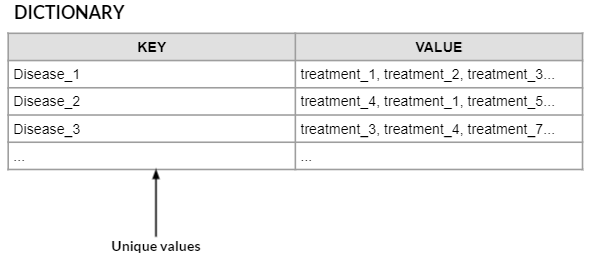

In [24]:
dict_ = {}
for i in range(len(Y_train)):
    idxD = []; idxT = []
    for j,label in enumerate(Y_train[i]):
        if label == 'D':
            idxD.append(j)
        if label == 'T':
            idxT.append(j)
    disease = ''
    diseases = []
    for idx in idxD:
        disease += sent_processed2[i].split()[idx]
        if idx+1 in idxD:
            disease += ' '
        else:
            diseases.append(disease)
            disease = ''
    treatment = ''
    treatments = []
    for idx in idxT:
        treatment += sent_processed2[i].split()[idx]
        if idx+1 in idxT:
            treatment += ' '
        else:
            treatments.append(treatment)
            treatment = ''
    for dis in diseases:
        dict_[dis] = treatments
#============================================
        
for i in range(len(Y_test)):
    idxD = []; idxT = []
    for j,label in enumerate(Y_test[i]):
        if label == 'D':
            idxD.append(j)
        if label == 'T':
            idxT.append(j)
    disease = ''
    diseases = []
    for idx in idxD:
        disease += test_sent_processed[i].split()[idx]
        if idx+1 in idxD:
            disease += ' '
        else:
            diseases.append(disease)
            disease = ''
    treatment = ''
    treatments = []
    for idx in idxT:
        treatment += test_sent_processed[i].split()[idx]
        if idx+1 in idxT:
            treatment += ' '
        else:
            treatments.append(treatment)
            treatment = ''
    for dis in diseases:
        dict_[dis] = treatments

In [25]:
new_dict = {}
for key, value in dict_.items():
    if value != []:
        new_dict[key] = value

### Predicts the treatment for the disease named 'hereditary retinoblastoma'

In [26]:
for d in new_dict.keys():
    if "retinoblastoma" in d.lower() or "hereditary retinoblastoma" in d.lower():
        print(new_dict[d])

['gene therapy']
